# Trading Strategy using Machine Learning

Author: [Alvaro Calle Cordon](www.linkedin.com/in/alvarocallecordon)  
Email: **alvaro.calle.cordon@gmail.com**  
Created: 22/11/2018  
Last Update: 14/05/2018

## Instructions

This notebook implements a trading strategy using machine learning. Here we focus on classification, specifically, we will forecast if a stock will move up and down, above some threshold such as the 90-day standard deviation.

#### Modelling

1. Decide on an algorithm or group of algorithms (for example, ensemble techniques).
2. Fit the model.
3. Show that it works out of sample, and use appropriate cross-validation techniques.
4. Provide the following performance metrics:  
    (a) ROC curves,  
    (b) Confusion Matrix,  
    (c) Precision, Recall, F1-Score, Accuracy, and AUC.  
5. Analysis of metrics and report.

#### Data

For this notebook we use High Frequency data. We downloaded a small sample, 20 days of tick data, E-mini S&P500 futures, 1 Sep 2013 to 20 Sep 2013. (Sourced from Tick Data LLC: https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/ES_Sample.zip)

---

## Consulted sources


#### Books and articles

- Advances in Financial Machine Learning. Marcos Lopez de Prado. https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086

- Kim, K.J. (2003). [Financial Time Series Forecasting Using Support Vector Machines. Neurocomputing, 55(1-2), pp.307-319.](https://www.researchgate.net/publication/222661136_Financial_time_series_forecasting_using_support_vector_machines)

- Patel, J., Shah, S., Thakkar, P. and Kotecha, K. (2015). [Predicting Stock Market Index Using Fusion of Machine Learning Techniques. Expert Systems with Applications, 42(4), pp.2162-2172.](https://www.sciencedirect.com/science/article/pii/S0957417414006551)

- Patel, J., Shah, S., Thakkar, P. and Kotecha, K. (2015). [Predicting Stock And Stock Price Index Movement Using Trend Deterministic Data Preparation and Machine Learning Techniques. Expert Systems with Applications, 42(1), pp.259-268.](https://www.sciencedirect.com/science/article/pii/S0957417414004473)

- Kara, Y., Boyacioglu, M.A. and Baykan, Ö.K. (2011). [Predicting Direction of Stock Price Index Movement Using Artificial Neural Networks And Support Vector Machines: The Sample of The Istanbul Stock Exchange. Expert systems with Applications, 38(5), pp.5311-5319.](https://www.sciencedirect.com/science/article/pii/S0957417410011711)

- [Quantopian on De Pardo's book](https://www.quantopian.com/posts/introduction-to-advances-in-financial-machine-learning-by-lopez-de-prado)

- [Technical Analysis python library - talib](https://towardsdatascience.com/trading-strategy-technical-analysis-with-python-ta-lib-3ce9d6ce5614)

- [Artificial Neural Network In Python Using Keras For Predicting Stock Price Movement](https://www.quantinsti.com/blog/artificial-neural-network-python-using-keras-predicting-stock-price-movement)

---  

## Index

- [1.- Data](#section1)  
- [2.- Feature Engineering: indicators](#section2)  
- [3.- Traditional ML approach: binary classifier on indicators](#section3)  
    - [3.1.- Exploratory Data Analysis](#section3.1)
    - [3.2.- Binary classification](#section3.2)
- [4.- Conclusions](#section4)
---

In [150]:
# load magics
%load_ext watermark
%load_ext autoreload

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
%watermark
%autoreload 2

# import user defined functions
#from src import utils

# import standard libs
import sys
import time
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import talib

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import warnings
warnings.filterwarnings("ignore")

# Setting seed for reproducability
RANDOM_STATE = 777
rnd = np.random.seed(RANDOM_STATE)  

print()
%watermark -p sys,time,re,os,json,pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,talib

2018-11-22T13:06:08+01:00

CPython 3.6.5
IPython 6.3.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit

sys 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
time unknown
re 2.2.1
os unknown
json 2.0.9
pandas 0.22.0
pandas_datareader 0.7.0
numpy 1.15.2
sklearn 0.19.1
statsmodels 0.8.0
scipy 1.0.1
matplotlib 2.2.2
seaborn 0.8.1
talib 0.4.17


#### User defined functions

In [152]:
def read_tick_data(file):
    """
    Read tick data provided by https://www.tickdata.com/

    :param file: data file with data in csv format
    """
    cols = ['Date','Time','Price','Volume']

    df = (pd.read_csv(file, header=0, usecols=cols, dtype={'Price': np.float64, 'Volume': np.float64})
          .rename(columns=dict((key, value) for (key, value) in zip(cols, map(str.lower,cols))))
          .assign(date_time = lambda x: (pd.to_datetime(x.date + x.time, format='%m/%d/%Y%H:%M:%S.%f')))
          .assign(dollar_volume = lambda x: x.price*x.volume) # dollar volume
          .drop(['date','time'], axis=1)
          .set_index('date_time')
          .drop_duplicates()
         )

    return df

def plot_sample_data(ini, end, ref_df, sub_df, bar_type, price_col, *args, **kwds):
    """
    Plot tick data together with bar
    
    :param ini: (str) initial date of the sample
    :param end: (str) final date of the sample
    :param ref_df: (dataframe) with original tick data    
    :param sub_df: (dataframe) with sampled data
    :param bar_type: (str) type of bar used
    :param price_col: (str) column identifying the price
    """
    
    ref = ref_df.loc[ini:end, price_col]
    sub = sub_df.loc[ini:end, price_col]
        
    fig, axes = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X', color='r', label=bar_type)

    for ax in axes[1:]: 
        ax.legend()
    plt.tight_layout()
    
    return

def time_bars(data, units):    
    """
    Time bars are sampled in units of time
    
    -- input
    :param data: (dataframe) price, volume, dollar_volume
    :param units: (int) multiple of seconds to be sampled

    -- output
    :output data: (dataframe) time bars
            price: average price on selected period
            ohlc: open, high, low, close prices on period
            volume: total volume on period
            dollar_volume: total price*volume on period
            vwap: volume-weighted average price on period
    """
    duration = str(units) + 'T'

    price = data.resample(duration, label='right')['price'].mean() 
    ohlc = data.resample(duration, label='right')['price'].ohlc()
    date_time = pd.DataFrame(ohlc.index, index=ohlc.index)
    volume = data.resample(duration, label='right')['volume'].sum()
    dollar_volume = data.resample(duration, label='right')['dollar_volume'].sum()
    vwap = dollar_volume / volume

    data = pd.concat([price, ohlc, volume, dollar_volume, vwap], axis=1)
    data.columns = ['price', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume', 'vwap']
    data.dropna(how='any', axis=0, inplace=True)

    return data

## 1.- Data
<a id='section1'></a>

We use tick data (E-mini S&P500 futures, 1 Sep 2013 to 20 Sep 2013) with a millisecond time stamp (HH:MM:SS.000) and additional information in the following eight (8) fields: 
 
* Date 
* Time 
* Price (filtered price) 
* Volume (except in a few markets pit trades do not show Volume) 
* Market Flag (P/E for Pit or Electronic trades) 
* Sales Condition (if available; see below for exchange-specific information) 
* Exclude Record Flag (flags off-exchange trades, i.e. EFPs and block trades) 
* Unfiltered Price

<img src="data_description.jpg" style="width:500;height:250px;">
<caption><center> **Figure**: Data description.</center></caption>

In [153]:
# Read in tick data:
fp = 'data/ES_Trades.csv'
pd.read_csv(fp, header=0, ).head(5)

,Symbol,Date,Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESU13,09/01/2013,17:00:00.083,1640.25,8,E,0,NaN,1640.25
1,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
2,ESU13,09/01/2013,17:00:00.083,1640.25,2,E,0,NaN,1640.25
3,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
4,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25


Tick data ingestion:

In [154]:
tick_file = '../data/ES_Trades.csv'
df = read_tick_data(tick_file)
df.head(5)

,price,volume,dollar_volume
date_time,,,
2013-09-01 17:00:00.083,1640.25,8.0,13122.00
2013-09-01 17:00:00.083,1640.25,1.0,1640.25
2013-09-01 17:00:00.083,1640.25,2.0,3280.50
2013-09-01 17:00:00.083,1640.25,12.0,19683.00
2013-09-01 17:00:00.083,1640.25,4.0,6561.00


In [155]:
df.describe()

,price,volume,dollar_volume
count,32594.000000,32594.000000,3.259400e+04
mean,1678.267871,63.552065,1.066767e+05
std,26.906032,69.140781,1.162467e+05
min,1630.750000,1.000000,1.630750e+03
25%,1654.250000,22.000000,3.662588e+04
50%,1680.000000,45.000000,7.601000e+04
75%,1700.750000,81.000000,1.357389e+05
max,1726.750000,1150.000000,1.893475e+06


In [156]:
# date range
date_1 = df.index.min()
date_2 = df.index.max()
print('Oldest date : ', date_1)
print('Newest date : ', date_2)

Oldest date :  2013-09-01 17:00:00.083000
Newest date :  2013-09-20 16:14:50.077000


OHLC price data (time bars)

In [157]:
df_time = time_bars(df, 1)
df_time.head()

,price,open,high,low,close,volume,dollar_volume,vwap
date_time,,,,,,,,
2013-09-01 17:01:00,1640.019231,1640.25,1641.00,1639.00,1640.00,1811.0,2970108.5,1640.037824
2013-09-01 17:02:00,1639.910714,1640.00,1640.25,1639.50,1639.75,401.0,657629.5,1639.973815
2013-09-01 17:03:00,1640.000000,1639.75,1640.50,1639.75,1640.50,72.0,118066.5,1639.812500
2013-09-01 17:04:00,1640.400000,1640.50,1640.50,1640.25,1640.25,99.0,162397.0,1640.373737
2013-09-01 17:05:00,1640.464286,1640.25,1640.75,1640.25,1640.75,138.0,226384.0,1640.463768


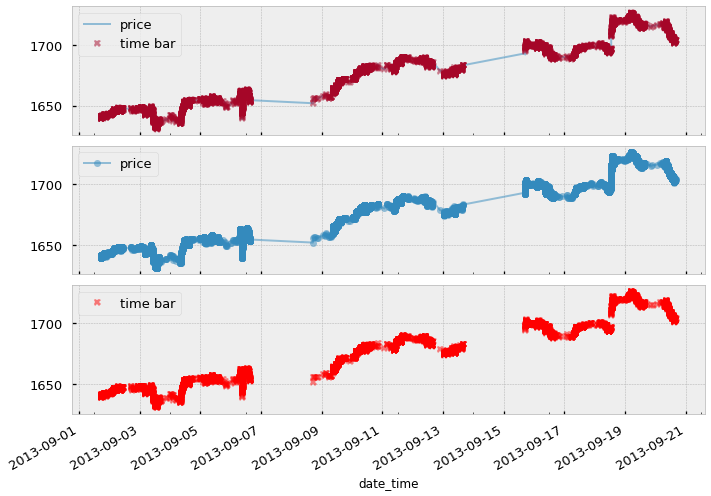

In [158]:
#ini = '2013-09-01 00:00:00'
#end = '2013-09-01 23:00:00'
ini = date_1
end = date_2

plot_sample_data(ini, end, df, df_time, 'time bar', 'price', alpha=0.5, markersize=7)

## 2.- Feature Engineering: indicators
<a id='section2'></a>

Here we will create the set of features that have been traditionally used in ML algos which are based on time bars. Notice that this is not an ideal setting as we should use better bars as proposed by De Prado. However we want to start from the beginning and keep improving our algo. Our study is inspired by the following works:

- Patel, J., Shah, S., Thakkar, P. and Kotecha, K. (2015). [Predicting Stock Market Index Using Fusion of Machine Learning Techniques. Expert Systems with Applications, 42(4), pp.2162-2172.](https://www.sciencedirect.com/science/article/pii/S0957417414006551)

- Patel, J., Shah, S., Thakkar, P. and Kotecha, K. (2015). [Predicting Stock And Stock Price Index Movement Using Trend Deterministic Data Preparation and Machine Learning Techniques. Expert Systems with Applications, 42(1), pp.259-268.](https://www.sciencedirect.com/science/article/pii/S0957417414004473)

- Kara, Y., Boyacioglu, M.A. and Baykan, Ö.K. (2011). [Predicting Direction of Stock Price Index Movement Using Artificial Neural Networks And Support Vector Machines: The Sample of The Istanbul Stock Exchange. Expert systems with Applications, 38(5), pp.5311-5319.](https://www.sciencedirect.com/science/article/pii/S0957417410011711)

The idea consists on defining a set of indicators for the prediction task of nth day ahead of time. These technical indicators which are used as inputs are summarized in the following table. This set of indicators, initially proposed by **Kara et. al**, have been used the selected features in several publications.

<img src="Indicators_1.JPG" style="width:800;height:450px;">
<caption><center> **Figure**: Selected indicators.</center></caption>

Some of the indicators that can be used are:

- SMA: Simple Moving Average (n-days)

> For a window of size $n$ we define the SMA as:
> 
> $$ SMA_t = \sum_{i=0}^{n} \frac{C_{t-i}}{n} $$

- EMA: Exponential Moving Average (n-days)

> The exponentially weighted moving average (EMA) is defined as:
> $$ EWA_t = \frac{\sum_{i=0}^{n} w_i C_{t-i}}{\sum_{i=0}^{n} w_i} \, , $$
> where $w_i$ are the weights. We use [pandas](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) implemantation of this function.

- MOM: Momentum

> Momentum, for a time window n, is defined as:
> $$ MOM = C_t - C_{t-n}\, . $$
> We calculate this value as the diference between the first value and the last value of the window.

- STCK: Stochastic K%

> The STCK is defined as:
> $$ STCK = \frac{ C_t - LL_{t-(n-1)} }{ HH_{t-(n-1)} - LL_{t-(n-1)} } \times 100  \, , $$
> where $LL_t$ and $HH_t$ implies lowest low and highest high in the last $t$ days, respectively.

- STCD: Stochastic D%

> The STCD is defined as the rolling mean of K%:
> $$ STCD = \frac{\sum_{i=0}^{n} K_{t-i}}{n}\, . $$

- MACD: Moving Average Convergence and Divergence

> This index is defined as the difference between the short-term (12-periods) EMA and long-term (26-periods) EMA:
> $$ MACD = EMA(12)_t - EMA(26)_t \, , $$
> where $$EMA(k)_t = EMA(k)_{t-1} + \alpha \left( C_t - EMA(k)_{t-1}\right)$$

- RSI: Relative Strength Index

> This index is defined as follows:
> $$ RSI = 100 - \frac{100}{1 + \frac{\sum_{i=0}^{n-1}UP_{t-i}/n}{\sum_{i=0}^{n-1}DW_{t-i}/n}} \, , $$
> where $UP_t$ means upward price change while $DW_t$ is the downward price change at time $t$.

- CCI: Commodity Channel Index

> The CCI is defined as:
> $$\begin{eqnarray*} 
CCI &=& \frac{M_t - SM_t}{0.015 D_t} \, , \text{where} \, , \\
M_t &=& \frac{H_t + L_t + C_t}{3}\, ,\\
M_t &=& \frac{\sum_{i=1}^{n} M_{t-i+1}}{n}\, ,\\
D_t &=& \frac{\sum_{i=1}^{n} |M_{t-i+1} - SM_t}{n}\, .
\end{eqnarray*}$$
> where the moving averages will be taken in a daily window.

- WR: Larry William's R%
- ADO: Accumulation/Distribution Oscilators

But we use [much more](http://www.tadoc.org/index.htm). Notice that the python library TA-lib is quite useful here as it has around 200 indicators already defined. As the main purpose of this assignment is to build a trading strategy, we will make use of this built-in library.

In [159]:
df_time[['price', 'open', 'high', 'low', 'volume']].head(3)

,price,open,high,low,volume
date_time,,,,,
2013-09-01 17:01:00,1640.019231,1640.25,1641.00,1639.00,1811.0
2013-09-01 17:02:00,1639.910714,1640.00,1640.25,1639.50,401.0
2013-09-01 17:03:00,1640.000000,1639.75,1640.50,1639.75,72.0


In [225]:
def create_features(dataset, target_type=1):
    """
    Function that creates the set of features and response variable to feed the ML algo. 
    The Function makes use of TA-lib to define the different indicators.
    
    -- inputs
    :param dataset: (dataframe) with bars data in OCHL format
    :param target_type: (int) indicating type of response
        0: price rise
        1: sell/buy                
        ... (more types can be added in the future
        
    -- outputs
    :output dataset: (dataframe) with constructed features and target variable (classes)
    """
    
    # dataset original columns
    cols = dataset.columns
    
    # overlap indicators
    dataset['H-L'] = dataset['high'] - dataset['low']
    dataset['O-C'] = dataset['close'] - dataset['open']
    
    dataset['5m_MA'] = dataset['close'].shift(1).rolling(window = 5).mean()
    dataset['15m_MA'] = dataset['close'].shift(1).rolling(window = 15).mean()
    dataset['30m_MA'] = dataset['close'].shift(1).rolling(window = 30).mean()
        
    dataset['5m_Std']= dataset['close'].rolling(5).std()
    dataset['15m_Std']= dataset['close'].rolling(15).std()
    dataset['30m_Std']= dataset['close'].rolling(30).std()

    dataset['5m_EMA'] = talib.EMA(dataset['close'].values, timeperiod = 5)     
    dataset['200m_EMA'] = talib.EMA(dataset['close'].values, timeperiod = 200) 
    dataset['SMA'] = talib.SMA(dataset['close'].values, timeperiod=30)
    dataset['TRIMA'] = talib.TRIMA(dataset['close'].values, timeperiod = 30) 
    dataset['WMA'] = talib.WMA(dataset['close'].values, timeperiod = 30) 

    # momentum indicators
    dataset['APO'] = talib.APO(dataset['close'].values, fastperiod=12, slowperiod=26)
    dataset['AROONOSC'] = talib.AROONOSC(dataset['high'].values, dataset['low'].values, timeperiod=14)
    dataset['BOP'] = talib.BOP(dataset['open'].values, dataset['high'].values, dataset['low'].values, dataset['close'].values)
    dataset['CCI'] = talib.CCI(dataset['high'].values, dataset['low'].values, dataset['close'].values, timeperiod=14)
    dataset['MACD'], _, _ = talib.MACD(dataset['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    dataset['MOM'] = talib.MOM(dataset['close'].values, timeperiod=10)
    dataset['PPO'] = talib.PPO(dataset['close'].values, fastperiod=12, slowperiod=26, matype=0)
    dataset['ROCP'] = talib.ROCP(dataset['close'].values, timeperiod=10)
    dataset['RSI'] = talib.RSI(dataset['close'].values, timeperiod = 9)
    dataset['Williams %R'] = talib.WILLR(dataset['high'].values, dataset['low'].values, dataset['close'].values, 7)
    dataset['SLOWK'], dataset['SLOWD'] = talib.STOCH(dataset['high'].values, dataset['low'].values, dataset['close'].values,
                                                     fastk_period=5, slowk_period=3, slowk_matype=0, 
                                                     slowd_period=3, slowd_matype=0)
    dataset['FASTK'], dataset['FASTD'] = talib.STOCHF(dataset['high'].values, dataset['low'].values, dataset['close'].values,
                                                      fastk_period=5, fastd_period=3, fastd_matype=0)    
    dataset['SAR'] = talib.SAR(dataset['high'].values, dataset['low'].values, 0.2, 0.2)
    dataset['ADX'] = talib.ADX(dataset['high'].values, dataset['low'].values, dataset['close'].values, 10)

    # volume Indicators
    dataset['AD'] = talib.AD(dataset['high'].values, dataset['low'].values, dataset['close'].values, dataset['volume'].values)
    dataset['ADOSC'] = talib.ADOSC(dataset['high'].values, dataset['low'].values, dataset['close'].values, dataset['volume'].values, fastperiod=3, slowperiod=10)
    dataset['OBV'] = talib.OBV( dataset['close'].values, dataset['volume'].values)
    
    # volatility Indicators
    dataset['ATR'] = talib.ATR(dataset['high'].values, dataset['low'].values, dataset['close'].values, timeperiod=14)
    dataset['TRANGE'] = talib.TRANGE(dataset['high'].values, dataset['low'].values, dataset['close'].values)

    # Pattern Recognition
    # ...

    # -----------------
    # labels
    # -----------------
    if target_type == 0: # price movement strategy
        dataset['target'] = np.where(dataset['close'].shift(-1) > dataset['close'], 1, 0)
    elif target_type == 1: # moving average strategy
        ma_short = dataset['5m_EMA']
        ma_long = dataset['200m_EMA']
        
        cross_sell = (ma_long.shift(-1) >= ma_short.shift(-1)).values * (ma_long < ma_short).values
        cross_buy = (ma_long.shift(-1) <= ma_short.shift(-1)).values * (ma_long > ma_short).values
        
        sell_idx = ma_long[cross_sell].index
        buy_idx = ma_long[cross_buy].index
        int_idx = ma_long.index.difference(sell_idx).difference(buy_idx)
        
        dataset.ix[sell_idx, 'target'] = 0
        dataset.ix[buy_idx, 'target'] = 1        
        dataset.ix[int_idx, 'target'] = 999
        
    # return clean dataset    
    dataset = dataset.dropna()

    return dataset

### Alternative 1: up/down price movement indicator

In this alternative we select `target_type=1` to explore whether we can predict up/down price movenents. We will see that our classification algorithm does not do very well in predicting these movements, i.e., it does not performs much better then random guessing according to the ROC. That was the first alternative that we tried and after seeing the results we decided to go for the second one.

In [226]:
df = df_time[['price', 'open', 'close', 'high', 'low', 'volume']]
dataset = create_features(df, 0)

split = int(len(dataset)*0.8)
df_train, df_test = dataset[:split], dataset[split:]

### Alternative 2: buy/sell indicator

Our logic behind this alternative is that in theory, according to technical analysis, moving averages give an indication of the `momentum` of a price. In particular, by comparing two moving averages of different lengths, one should be able to infer that the momentum of a the stock is changing, giving a signal when to buy or sell the stock. This comparison between two moving averages is done by finding so-called crossover points between different moving averages. For example, some advocates of technical analysis claim that by looking at the short-period and long-period moving averages of a stock price, one can identify longer trends and benefit from them. 

This works as follows:
- We keep track of two moving averages of different lengths: a shorter one and a longer one
- When the shorter MA `crosses` the longer one (it has been lower but becomes higher), this is a signal to buy the stock as it seems to be gaining momentum. More specifically, if for any time $t$, $MA_H(t - 1) >= MA_L(t - 1)$ and $MA_L(t) > MA_H(t)$, you should buy the stock. 

We next show an example of such theory in our case. For that, we look at two EMAs:

In [227]:
df = df_time[['price', 'open', 'close', 'high', 'low', 'volume']]
dataset = create_features(df, 1)

split = int(len(dataset)*0.8)
df_train, df_test = dataset[:split], dataset[split:]

In the following figure we plot the two moving averages in a short period of time, together with the labels indicating where to buy or where to sell. As we can see, the two-distance-moving averaging method is an apparently good indicator of the position selection. We will use these labels in our classification algo.

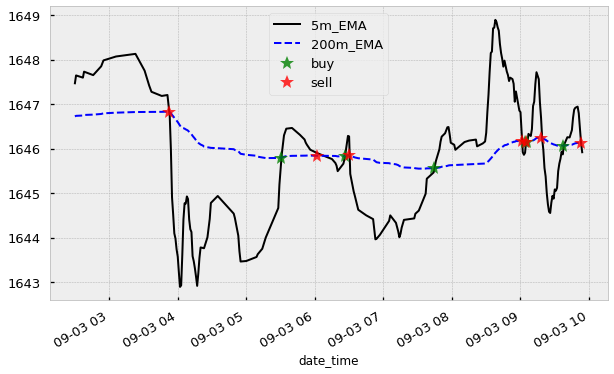

In [231]:
plt.figure(figsize=(10,6))
dataset['5m_EMA'][200:400].plot(style='-', color='black')
dataset['200m_EMA'][200:400].plot(style='--', color='blue')
plt.plot(dataset[200:400][dataset.target == 1].index, dataset[200:400].loc[dataset.target == 1, '200m_EMA'].values, linestyle='None', marker='*', color='green', markersize=15, alpha=0.8, label='buy')
plt.plot(dataset[200:400][dataset.target == 0].index, dataset[200:400].loc[dataset.target == 0, '200m_EMA'].values, linestyle='None', marker='*', color='red', markersize=15, alpha=0.8, label='sell')
plt.legend()

## 3.- Traditional ML approach: binary classifier on indicators
<a id='section3'></a>

Alternative 2: sell/buy dataset

In [251]:
df = df_time[['price', 'open', 'close', 'high', 'low', 'volume']]
dataset = create_features(df, 1)

We remove examples not labeled in alternative 2 (this is not necesary when we use alternative 1 trading strategy):    

In [252]:
dataset.target.unique()

array([999.,   0.,   1.])

In [255]:
dataset = dataset[dataset.target != 999]

Train/Test set split

In [256]:
split = int(len(dataset)*0.8)
df_train, df_test = dataset[:split], dataset[split:]

Date range in train and test sets:

In [257]:
print('Date range in the training set: [{0}, {1}]'.format(df_train.index.min(), df_train.index.max()))
print('Date range in the hold-out set: [{0}, {1}]'.format(df_test.index.min(), df_test.index.max()))

Date range in the training set: [2013-09-03 03:52:00, 2013-09-17 07:49:00]
Date range in the hold-out set: [2013-09-18 08:33:00, 2013-09-20 08:44:00]


Before applying any ML algorithm we have to normalize the data in order to avoid one particular feature to dominate and bias the result of the algorithm.

In [260]:
from sklearn import preprocessing

# MinMax normalization
cols_normalize = df_train.columns.difference(['target', 'price', 'open', 'close', 'high', 'low', 'volume'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_train.index)

# overwrite train df
df_train = norm_df_train.join(df_train.target)
df_train.head(2)

,15m_MA,15m_Std,200m_EMA,30m_MA,30m_Std,5m_EMA,5m_MA,5m_Std,AD,ADOSC,...,RSI,SAR,SLOWD,SLOWK,SMA,TRANGE,TRIMA,WMA,Williams %R,target
date_time,,,,,,,,,,,,,,,,,,,,,
2013-09-03 03:52:00,0.209385,0.214117,0.172932,0.217199,0.130109,0.177134,0.183307,0.104430,0.219462,0.426418,...,0.230499,0.193324,0.314815,0.388889,0.214874,0.333333,0.21942,0.207860,1.110223e-16,0.0
2013-09-03 05:30:00,0.159143,0.517535,0.156414,0.159869,0.271514,0.154448,0.150546,0.657499,0.185087,0.402608,...,0.795843,0.148957,0.988889,0.966667,0.159002,0.111111,0.16462,0.159015,9.090909e-01,1.0


Next, we prepare the test set. We first normalize the test data using the parameters from the MinMax normalization applied on the training set. 

In [261]:
# normalize test set
norm_df_test = pd.DataFrame(min_max_scaler.transform(df_test[cols_normalize]),
                       columns=cols_normalize, 
                       index=df_test.index)

# overwrite test df
df_test = norm_df_test.join(df_test.target)
df_test.head(2)

,15m_MA,15m_Std,200m_EMA,30m_MA,30m_Std,5m_EMA,5m_MA,5m_Std,AD,ADOSC,...,RSI,SAR,SLOWD,SLOWK,SMA,TRANGE,TRIMA,WMA,Williams %R,target
date_time,,,,,,,,,,,,,,,,,,,,,
2013-09-18 08:33:00,0.986993,0.143584,0.992350,0.993055,0.144789,0.989447,0.978939,0.233220,0.653177,0.572694,...,0.220824,0.977011,0.655556,0.733333,0.993032,0.555556,0.992259,0.993251,0.2,0.0
2013-09-18 08:36:00,0.983933,0.172553,0.992193,0.990782,0.175705,0.984136,0.977379,0.327962,0.653177,0.543888,...,0.265178,0.973180,0.422222,0.133333,0.991005,0.111111,0.989982,0.990332,0.2,1.0


Check we have the same columns in both DataFrames after normalization

In [262]:
sum(df_test.columns != df_train.columns)

0

### 3.1.- Exploratory Data Analysis
<a id='section3.1'></a>

In [263]:
print(df_train.columns)

Index(['15m_MA', '15m_Std', '200m_EMA', '30m_MA', '30m_Std', '5m_EMA', '5m_MA',
       '5m_Std', 'AD', 'ADOSC', 'ADX', 'APO', 'AROONOSC', 'ATR', 'BOP', 'CCI',
       'FASTD', 'FASTK', 'H-L', 'MACD', 'MOM', 'O-C', 'OBV', 'PPO', 'ROCP',
       'RSI', 'SAR', 'SLOWD', 'SLOWK', 'SMA', 'TRANGE', 'TRIMA', 'WMA',
       'Williams %R', 'target'],
      dtype='object')


Plot and compare the standard deviation of input features:

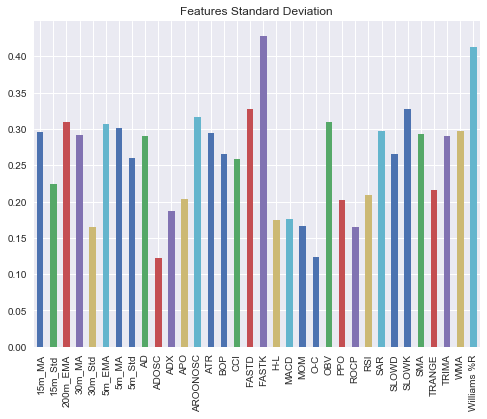

In [264]:
df_train.iloc[:,:-1].std().plot(kind='bar', figsize=(8,6), title="Features Standard Deviation")

Ordered list of top variance features:

In [265]:
df_train.iloc[:,:-1].std().sort_values(ascending=False)

FASTK          0.427710
Williams %R    0.412185
SLOWK          0.326861
FASTD          0.326861
AROONOSC       0.315783
200m_EMA       0.309695
OBV            0.309056
5m_EMA         0.307141
5m_MA          0.301511
SAR            0.297444
WMA            0.296716
15m_MA         0.295649
ATR            0.294335
SMA            0.292756
30m_MA         0.291776
TRIMA          0.290534
AD             0.289828
SLOWD          0.265238
BOP            0.265084
5m_Std         0.259722
CCI            0.259153
15m_Std        0.224693
TRANGE         0.216483
RSI            0.208902
APO            0.203929
PPO            0.202485
ADX            0.187445
MACD           0.176275
H-L            0.174813
MOM            0.165660
ROCP           0.164921
30m_Std        0.164875
O-C            0.123308
ADOSC          0.122430
dtype: float64

Ordered list of features correlating with classification label `Price_Rise`

In [266]:
corr = df_train.iloc[:,:-1].corrwith(df_train.target).sort_values(ascending=False)
corr

FASTK          0.637882
Williams %R    0.628818
CCI            0.593008
RSI            0.579820
SLOWK          0.520471
FASTD          0.520471
MOM            0.478955
ROCP           0.477828
SLOWD          0.341487
BOP            0.272851
O-C            0.266800
AROONOSC       0.254652
ADOSC          0.241029
30m_Std        0.198544
MACD           0.168684
APO            0.084955
PPO            0.084285
15m_Std        0.057152
ATR            0.028747
ADX           -0.006563
OBV           -0.014996
200m_EMA      -0.022904
AD            -0.030431
5m_EMA        -0.031162
5m_MA         -0.044843
WMA           -0.046267
SMA           -0.047426
30m_MA        -0.048599
15m_MA        -0.048894
TRIMA         -0.050386
SAR           -0.056075
TRANGE        -0.083930
H-L           -0.095942
5m_Std        -0.119906
dtype: float64

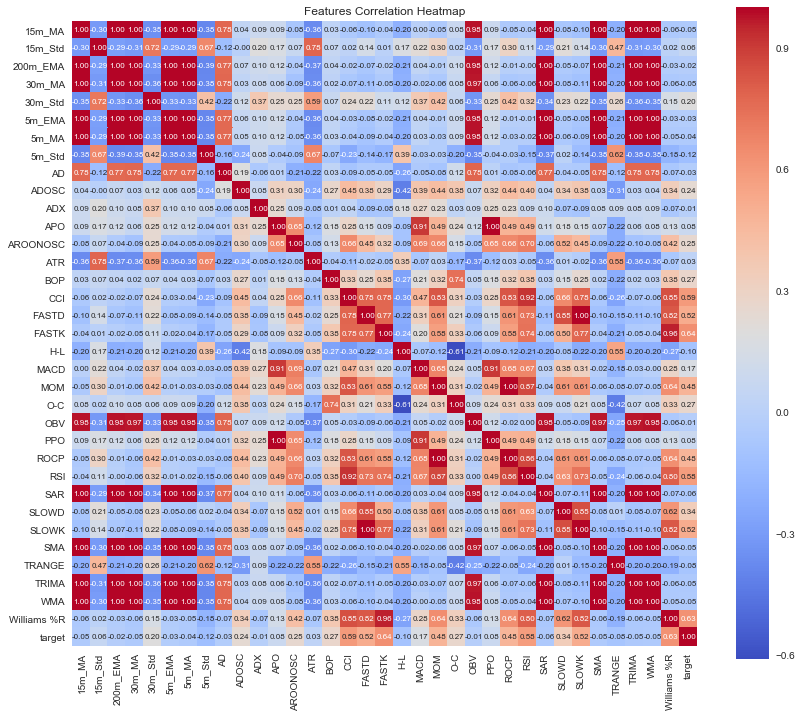

In [267]:
cm = df_train.corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(14, 12))
hm = sns.heatmap(cm, cbar=True, cmap='coolwarm', annot=True, square=True, fmt='.2f', annot_kws={'size': 8})
plt.title('Features Correlation Heatmap')
plt.show()

We now explore each feature independently using a set of plots.

In [270]:
def explore_col(df, fname, cname, alternative='sell-buy'):
    """
    Plot 3 main graphs for a single feature.
    
        plot1: histogram 
        plot2: boxplot 
        plot3: time series by class
        
    Args:
        df (pandas): DataFrame with features and labels
        fname (str): The column name of the feature to be plotted.
        cname (str): The column name of the class.
        alter (str): The strategy alternative (price-swing or sell-buy)

    Returns:
        plots    
    """
    
    fig = plt.figure(figsize=(14, 4))

    # histogram
    sub1 = fig.add_subplot(131)
    sub1.set_title(fname + ' histogram') 
    sub1.hist(df[fname], bins=50, density=True, facecolor='g', alpha=0.75)

    # Tukey boxplot
    sub2 = fig.add_subplot(132)
    sub2.set_title(fname + ' boxplot')
    sub2.boxplot(df[fname], sym='r*')
           
    # Time series
    if alternative == 'sell-buy':
        label1 = 'buy'
        label2 = 'sell'
    elif alternative == 'price-swing':
        label1 = 'price up'
        label2 = 'price down'

    cmask = df[cname] == 1
    sub3 = fig.add_subplot(133)
    sub3.set_title(fname + ' time series')
    sub3.set_xlabel('time')
    sub3.plot(df[cmask].index, df.loc[cmask, fname], linestyle='None', marker='^', color='green', markersize=5, label=label1, alpha=0.8)
    sub3.plot(df[cmask].index, df.loc[cmask, fname], linestyle='None', marker='v', color='red', markersize=5, label=label2, alpha=0.8)
    sub3.legend()
    for tick in sub3.get_xticklabels():
        tick.set_rotation(45)
        
    plt.tight_layout()
    plt.show()

We now plot, for each of the features, a set of statistics in order to have a visual interpretation of them. Specifically we plot:

- Histogram of values
- Tukey's Boxplot
- Time series by class (up/down trends)

We can see that some features distribute normally while others do not. Also, we have non-trading data periods.


 -- Feature: 15m_MA



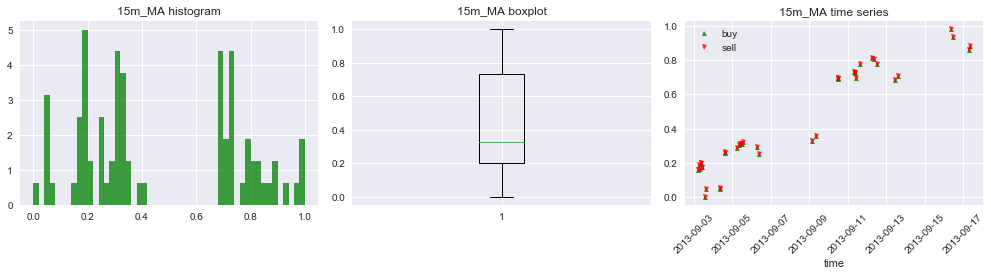


 -- Feature: 15m_Std



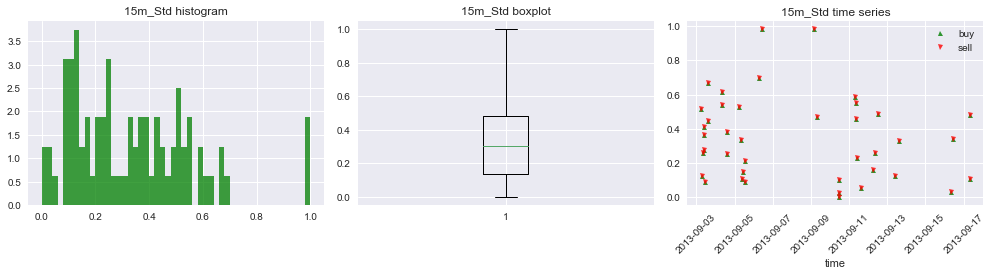


 -- Feature: 200m_EMA



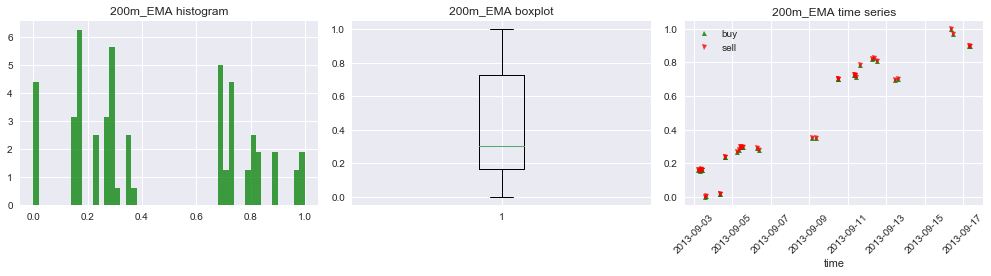


 -- Feature: 30m_MA



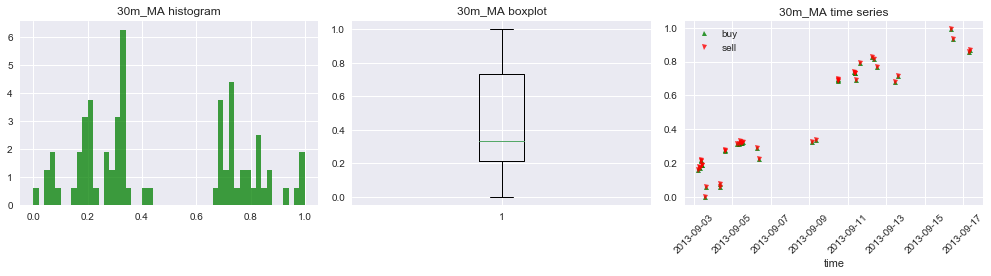


 -- Feature: 30m_Std



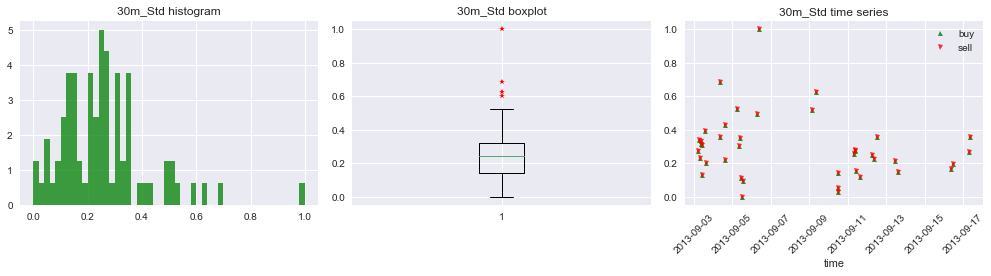


 -- Feature: 5m_EMA



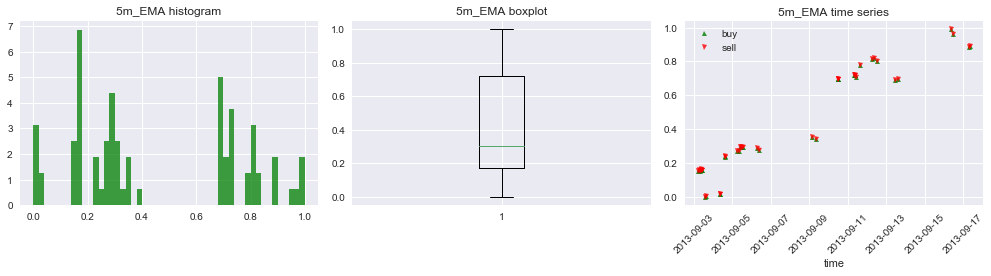


 -- Feature: 5m_MA



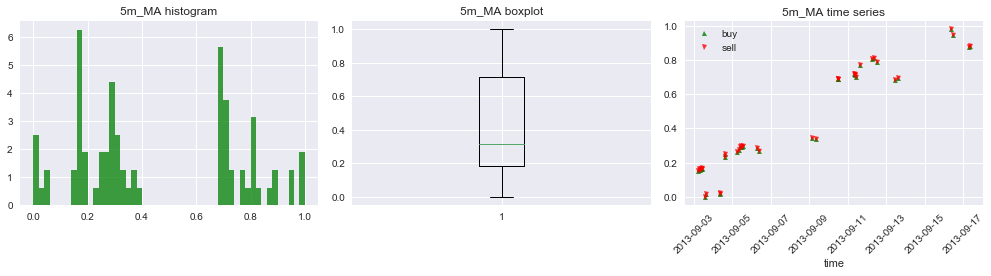


 -- Feature: 5m_Std



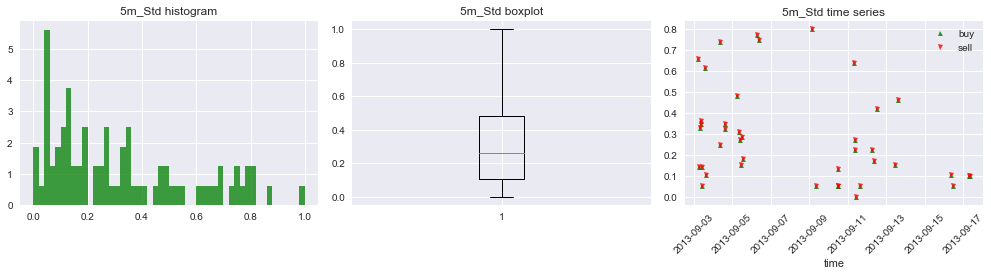


 -- Feature: AD



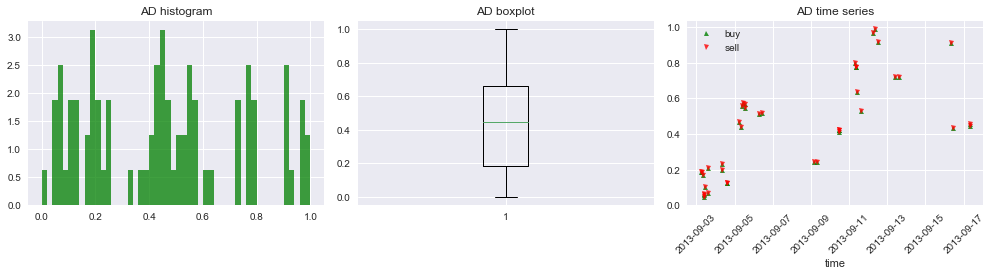


 -- Feature: ADOSC



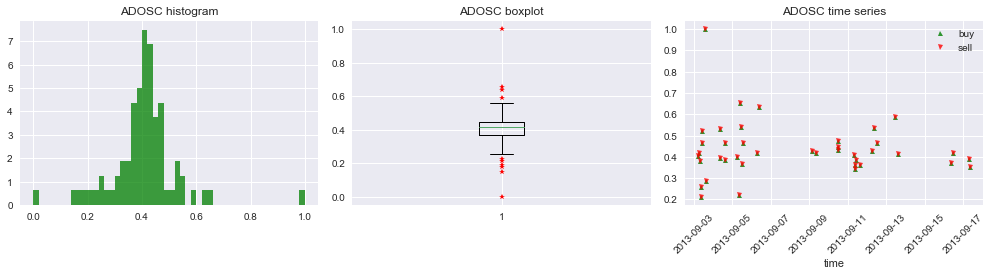


 -- Feature: ADX



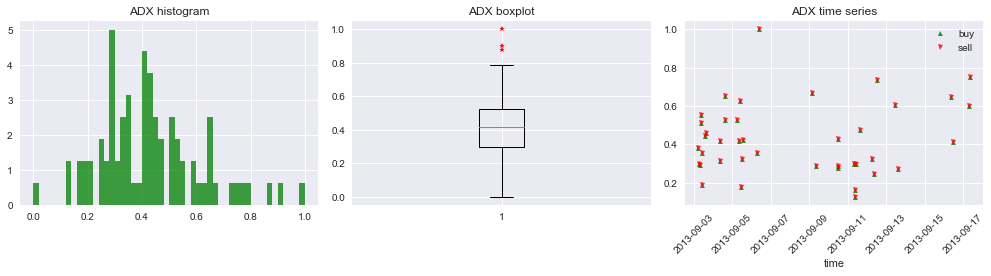


 -- Feature: APO



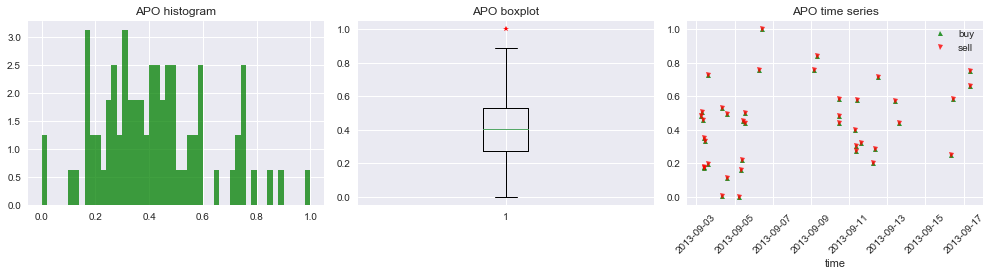


 -- Feature: AROONOSC



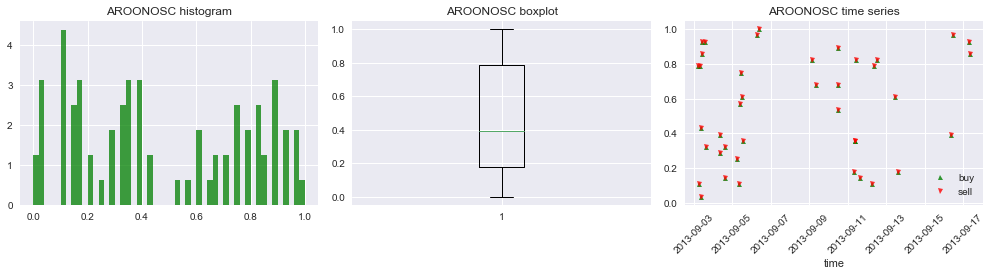


 -- Feature: ATR



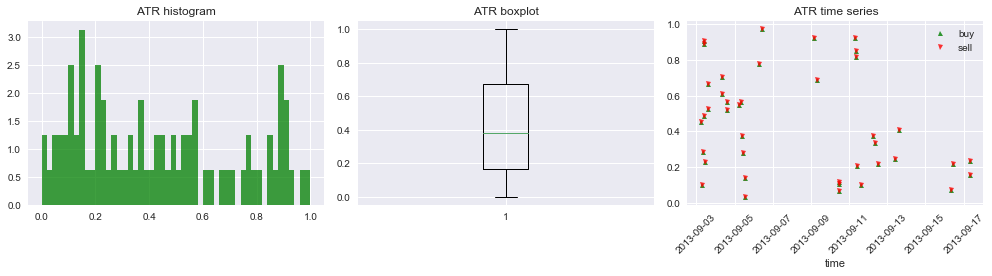


 -- Feature: BOP



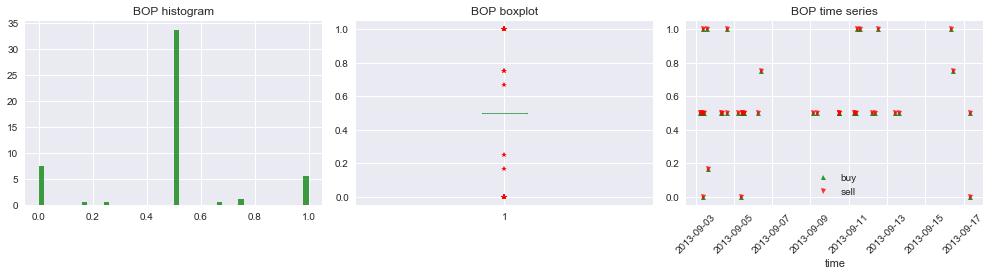


 -- Feature: CCI



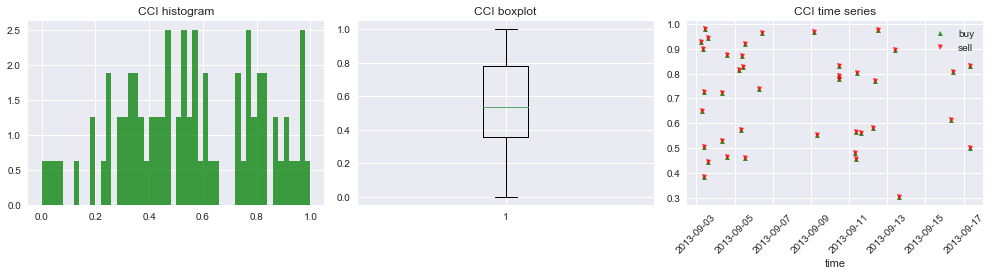


 -- Feature: FASTD



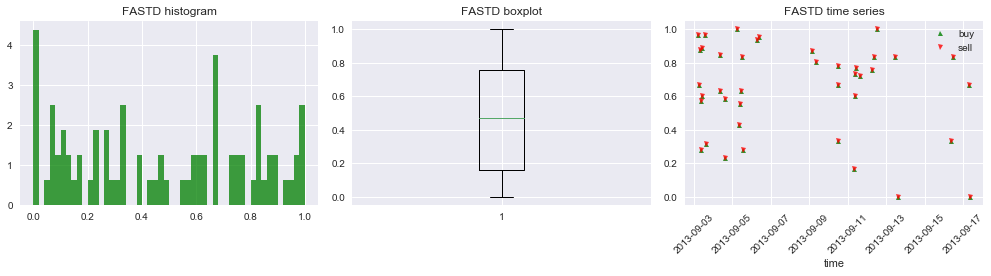


 -- Feature: FASTK



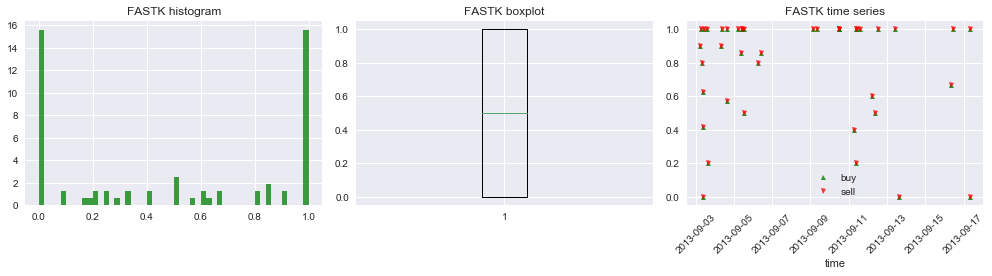


 -- Feature: H-L



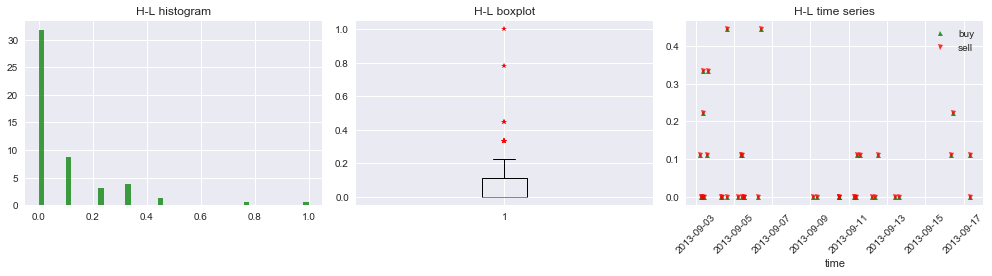


 -- Feature: MACD



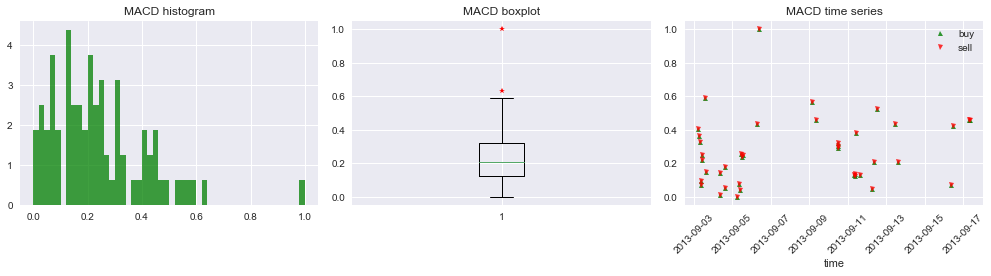


 -- Feature: MOM



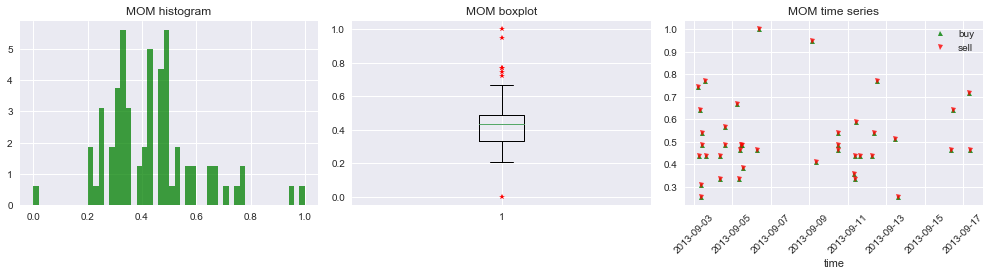


 -- Feature: O-C



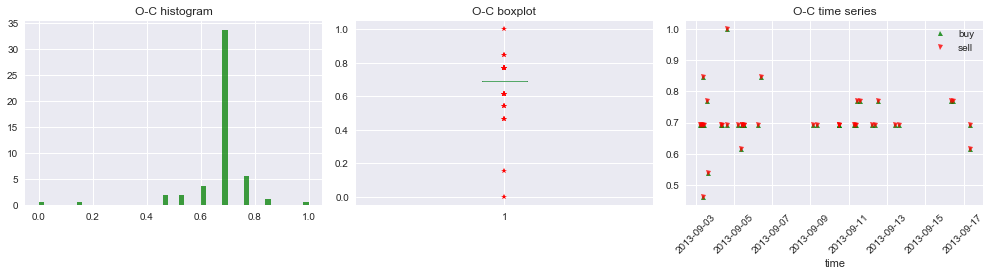


 -- Feature: OBV



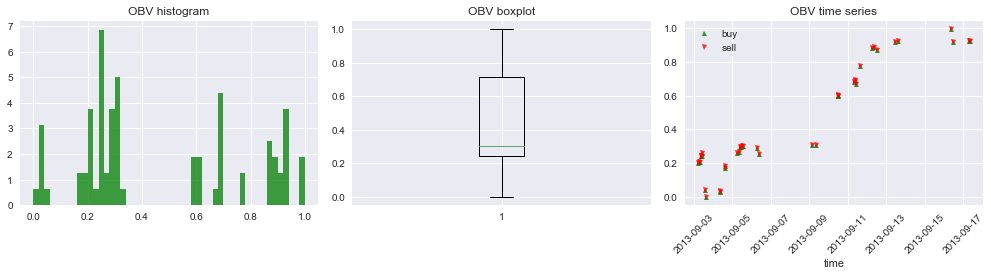


 -- Feature: PPO



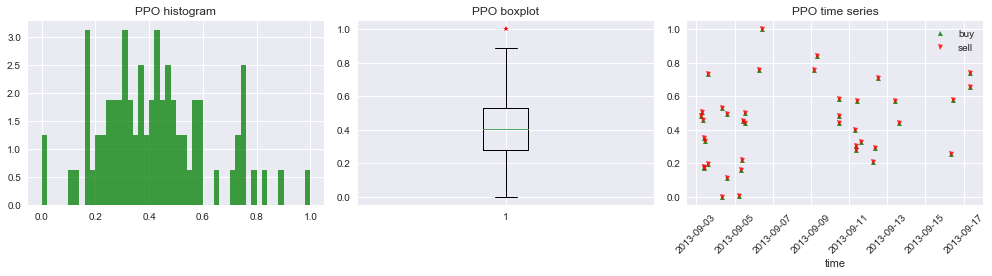


 -- Feature: ROCP



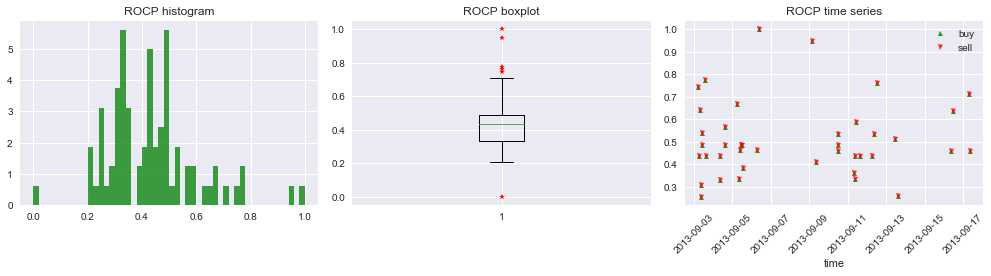


 -- Feature: RSI



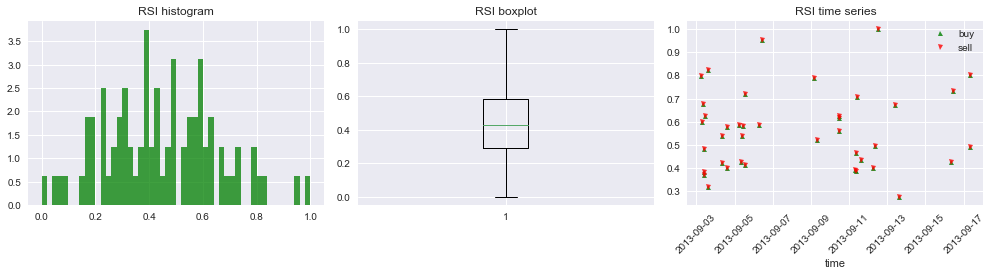


 -- Feature: SAR



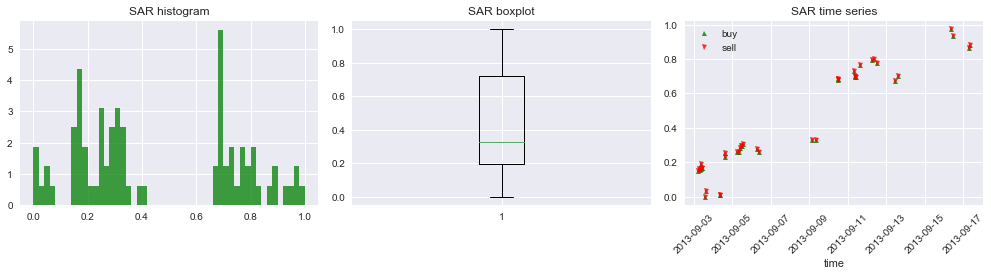


 -- Feature: SLOWD



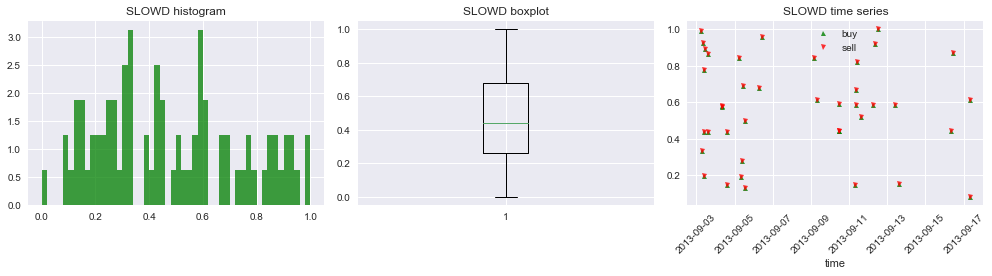


 -- Feature: SLOWK



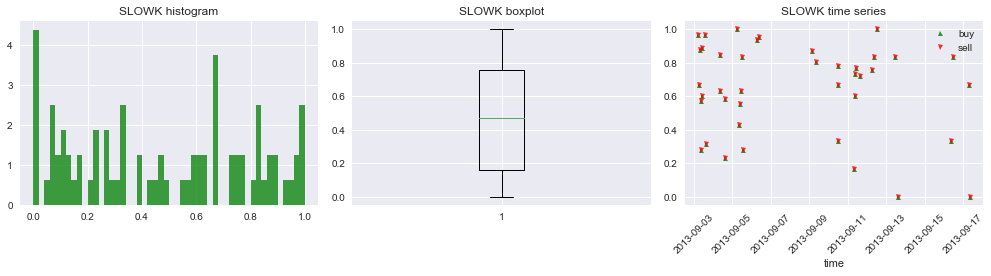


 -- Feature: SMA



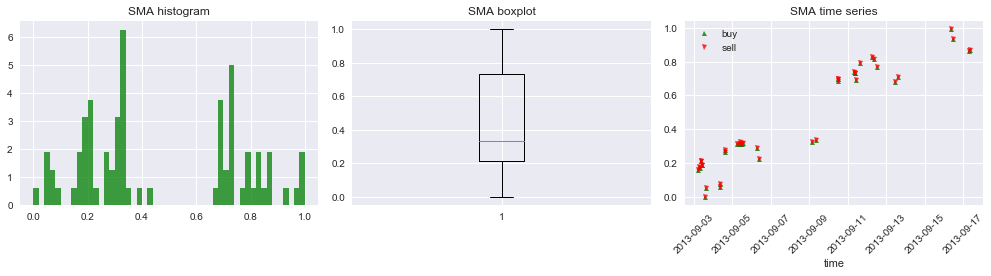


 -- Feature: TRANGE



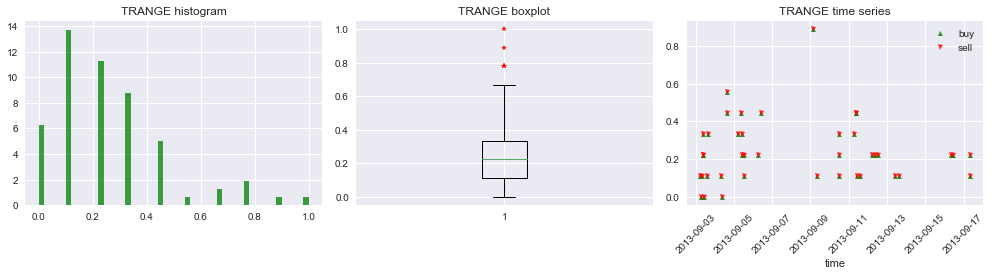


 -- Feature: TRIMA



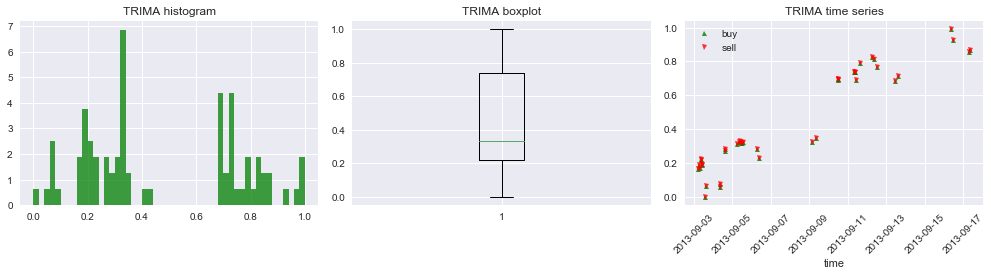


 -- Feature: WMA



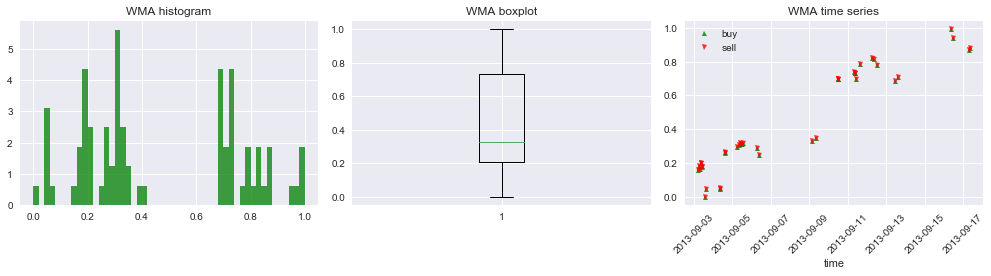


 -- Feature: Williams %R



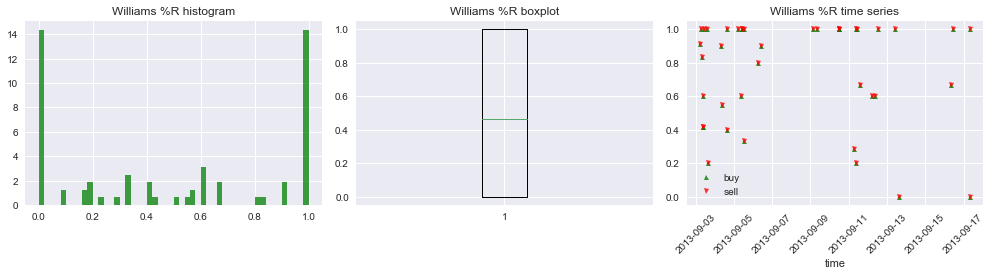

In [271]:
for fname in cols_normalize:
    print("\n -- Feature: {0}\n".format(fname))
    explore_col(df_train, fname, 'target', 'sell-buy')

Check dataset balance: 

In [272]:
df_train.target.value_counts()

1.0    40
0.0    40
Name: target, dtype: int64

Class 0: 40
Class 1: 40
Proportion: 1.0 : 1


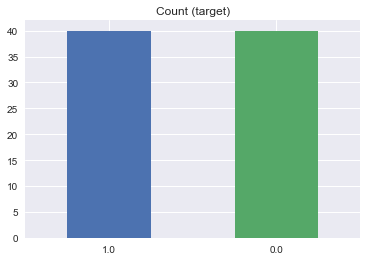

In [273]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

print('Class 0:', count_class_0)
print('Class 1:', count_class_1)
print('Proportion:', round(count_class_1 / count_class_0, 2), ': 1')

plt.figure(figsize=(6, 4))
df_train.target.value_counts().plot(kind='bar', title='Count (target)');
plt.xticks(rotation=0);

In the case of alternative 1 (price swing) the data set is imbalanced while in the case of alternative 2 (sell-buy) the dataset is perfectly balanced. 

In the case alternative 1 we have to apply some balance method. One of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like `accuracy_score` can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

A widely adopted technique for dealing with highly unbalanced datasets is called **resampling**. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

What follows only apply to inbalenced datasets:

In [274]:
# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [275]:
print(df_class_0.shape)
print(df_class_1.shape)

(40, 35)
(40, 35)


#### Random under-sampling

Random under-sampling:
1.0    40
0.0    40
Name: target, dtype: int64


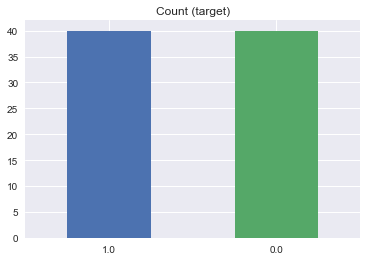

In [276]:
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.target.value_counts())

plt.figure(figsize=(6, 4))
df_train_under.target.value_counts().plot(kind='bar', title='Count (target)');
plt.xticks(rotation=0);

#### Random over-sampling

Random over-sampling:
1.0    40
0.0    40
Name: target, dtype: int64


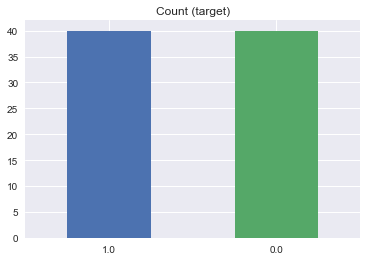

In [277]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over.target.value_counts())

plt.figure(figsize=(6, 4))
df_train_over.target.value_counts().plot(kind='bar', title='Count (target)');
plt.xticks(rotation=0);

We now have a balance dataset to which we apply our ML algorithm properly.

In [278]:
# alternative 1: price swing
#data = {'X_train': df_train_over.iloc[:,:-1], 'X_test': df_test.iloc[:,:-1],
#        'y_train': df_train_over.iloc[:,-1], 'y_test': df_test.iloc[:,-1]}

# alternative 2: sell byt
data = {'X_train': df_train.iloc[:,:-1], 'X_test': df_test.iloc[:,:-1],
        'y_train': df_train.iloc[:,-1], 'y_test': df_test.iloc[:,-1]}

### 3.2.-Binary classification
<a id='section3.2'></a>

In [279]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

Helper fuction: Binary classifier parameter tuning

In [280]:
def binary_classifier(data, model, clf, features, params=None, score=None):
    
    """
    Perform a grid search hyper parameter tuning on a classifier.

    Args:
        data (dict): dictionary with train and test DataFrames {'train': df_train, 'test': df_test}
        model (str): The model name identifier
        clf (classifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Classifier object
        dataframe of model predictions and scores

    Reference function used: 

    GridSearchCV(estimator : estimator object (clf)
                 param_grid : dict with parameters names (string) as keys 
                              and lists of parameter settings to try as values
                 scoring : 'accuracy', 'average_precision', 
                           'f1', 'f1_micro', 'f1_macro', 'f1_weighted, 'f1_samples', 
                           'neg_log_loss', 'precision', 'recall', 'roc_auc'
                 fit_params :  (dict) parameters to pass to the fit method
                 n_jobs : number of jobs to run in parallel
                 pre_dispatch : controls the jobs in parallel execution (None, Int, string like '2*n_jobs'
                 iid : boolean assume data to be iid
                 refit : refit an estimator using the best found parameters on the whole dataset
                 cv : cross-validation splitting strategy
                 verbose : controls messages
                 error_score : --
                 return_train_score : --
                 )
    """
    
    # retrieve train and test data:    
    X_train = data['X_train'][features]
    y_train = data['y_train']
    X_test = data['X_test'][features]
    y_test = data['y_test']
    
    grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    # .predict_proba(X_test) : (N,k)-matrix stating probability of example belongs to classes k
    # y_score = Probability(example) belongs to class 1    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In order to test our classifier we will compute some metrics. The meaning of each of these metrics is displayed in the following figure:

<img src="bin_class_metrics.JPG" style="width:600;height:350px;">
<caption><center> **Figure**: Binary classification metrics.</center></caption>

Helper function: binary [classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics):

In [301]:
def binary_class_metrics(model, y_dict, print_out=True, plot_out=True):
    
    """
    Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_dict (dict): {'test': y_test, 'pred': y_pred, 'score': y_score}
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics (Accuracy, Precision, Recall, F1 Score, ROC AUC)
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold
        plot: TPR-FPR threshold
        
    """

    # get y_test, y_pred, y_score from dict
    y_test = y_dict['test']
    y_pred = y_dict['pred']
    y_score = y_dict['score']
   
    binary_metrics = {
                        # accuracy = sum(y_test == y_pred)/len(y_test)
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),        
        
                        # precision = sum((y_test==1)*(y_pred==1))/sum(y_pred==1)
                        'Precision' : metrics.precision_score(y_test, y_pred),        
        
                        # recall = sum((y_test==1)*(y_pred==1))/sum(y_test==1)
                        'Recall' : metrics.recall_score(y_test, y_pred),        
        
                        # F1 = 2./(1./precision + 1./recall)
                        'F1 Score' : metrics.f1_score(y_test, y_pred),         
        
                        # area under the ROC curve
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score) 
                     }

    df_metrics = pd.DataFrame.from_dict(binary_metrics, orient='index')
    df_metrics.columns = [model]
    
    print("\n", df_metrics)

    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
   
    roc = []  
    for thr in thresh_roc:  
        roc.append((y_score >= thr).mean())

    roc = np.array(roc)

    roc_thresh = {
        'Threshold' : thresh_roc,
        'TPR' : tpr,
        'FPR' : fpr,
        'Que' : roc
    }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    prc = []  
    for thr in thresh_prc:  
        prc.append((y_score >= thr).mean())

    prc = np.array(prc)

    prc_thresh = {
        'Threshold' : thresh_prc,
        'Precision' : precision,
        'Recall' : recall,
        'Que' : prc
    }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        #print('\nROC Thresholds:\n')
        #print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])
        #print('\nPrecision-Recall Thresholds:\n')
        #print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        
        print('-----------------------------------------------------------')
        print(model, '\n')
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        # plot: AUC ROC       
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_title('AUC ROC Curve')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        # plot: Precision-Recall
        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_title('Precision-Recall Curve')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        # plot: TPR-FPR threshold
        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green', label='TPR') 
        ax3.plot(thresh_roc, roc, color='blue', label='Price Rise') 
        ax3.set_ylim([0.0, 1.05])
        ax2.set_title('TPR-FPR Threshold Curve')
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        # plot: Precision-Recall threshold
        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')
        ax4.plot(thresh_prc, recall, color='green', label='Recall')
        ax4.plot(thresh_prc, prc, color='blue', label='Price Rise')
        ax4.set_ylim([0.0, 1.05])
        ax2.set_title('Precision-Recall Threshold Curve')
        ax4.set_xlabel('Threshold')
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh

Using the above functions let us model and evaluate some binary classification algorithms. We also plot the ROC and Precision-Recall curves.

In [294]:
models = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "SVC",   
    "NuSVC",
    "Nearest Neighbors",
    "Neural Nets",
    "Ada Boost",
    "XG Boost",    
    "Gradient Boosting",
]

classifiers = [
    LogisticRegression(random_state=rnd),
    DecisionTreeClassifier(random_state=rnd),
    RandomForestClassifier(random_state=rnd),   
    SVC(random_state=rnd),
    NuSVC(random_state=rnd),
    KNeighborsClassifier(n_jobs=-1),
    MLPClassifier(random_state=rnd),
    AdaBoostClassifier(random_state=rnd),
    XGBClassifier(random_state=rnd, seed=0),
    GradientBoostingClassifier(random_state=rnd),
]

grid_search = [
    {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']},    
    {'max_depth': [2, 3, 4, 5, 6], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']},
    {'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 8, 10], 'bootstrap':[True, False]},
    {'C': [0.025, 0.05, 0.1], 'kernel': ['linear', 'poly', 'rbf']}, 
    {'nu': [0.025, 0.05, 0.1], 'kernel': ['linear', 'poly', 'rbf']},    
    {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
    {'hidden_layer_sizes': [(100,), (100,50), (30,30,30), (50,100,50)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd'], 'alpha': [0.0001, 0.001, 0.01, 0.1]},
    {'n_estimators': [10, 25, 50, 100], 'learning_rate': [0.01, 0.1, 1.0]},
    {'max_depth':[6, 7, 8], 'learning_rate':[0.01, 0.025, 0.05], 'subsample':[0.8, 1.0], 'n_estimators': [50, 100, 200, 500]},
    {'loss': ['deviance', 'exponential'], 'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [10, 25, 50, 100]}, 
]

We now apply these classifiers to selected features. We can decide whether to keep those used in the above cited references or selected uncorrelated ones from the correlation matrix.

In [297]:
df_train.columns

Index(['15m_MA', '15m_Std', '200m_EMA', '30m_MA', '30m_Std', '5m_EMA', '5m_MA',
       '5m_Std', 'AD', 'ADOSC', 'ADX', 'APO', 'AROONOSC', 'ATR', 'BOP', 'CCI',
       'FASTD', 'FASTK', 'H-L', 'MACD', 'MOM', 'O-C', 'OBV', 'PPO', 'ROCP',
       'RSI', 'SAR', 'SLOWD', 'SLOWK', 'SMA', 'TRANGE', 'TRIMA', 'WMA',
       'Williams %R', 'target'],
      dtype='object')

In [298]:
features = ['H-L',
            'O-C',
            '5m_EMA', 
            '200m_EMA', 
            #'5m_MA',
            #'15m_MA', 
            '30m_MA', 
            #'5m_Std',
            #'15m_Std', 
            '30m_Std', 
            #'SMA',                
            'TRIMA', 
            'WMA', 
            'APO', 
            'AROONOSC', 
            'BOP', 
            'CCI',
            'MACD', 
            'MOM', 
            'PPO', 
            'ROCP', 
            'RSI', 
            'Williams %R', 
            'SLOWK', 
            'SLOWD',
            'FASTK', 
            'FASTD', 
            #'SAR', 
            'ADX', 
            'AD', 
            'ADOSC', 
            #'OBV', 
            'ATR', 
            'TRANGE'
            ]

In [299]:
metrics_df = pd.DataFrame(index={'Accuracy',
                                 'Precision',
                                 'Recall',
                                 'F1 Score',
                                 'ROC AUC'}, columns=models)


 model: Logistic Regression 
 classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 grid search parameters: {'C': [0.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}



Best Parameters:
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

            Logistic Regression
Accuracy              0.761905
Precision             1.000000
Recall                0.500000
F1 Score              0.666667
ROC AUC               0.709091
-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[11  0]
 [ 5  5]]

Classificatio


Best Parameters:
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

            Neural Nets
Accuracy      0.761905
Precision     1.000000
Recall        0.500000
F1 Score      0.666667
ROC AUC       0.781818
-----------------------------------------------------------
Neural Nets 

Confusion Matrix:
[[11  0]
 [ 5  5]]

Classification Report:
             precision    recall  f1-score   support

        0.0       0.69      1.00      0.81        11
        1.0       1.00      0.50      0.67        10

avg / total       0.84      0.76      0.74        21


Metrics:
           Neural Nets
Accuracy      0.761905
Pr

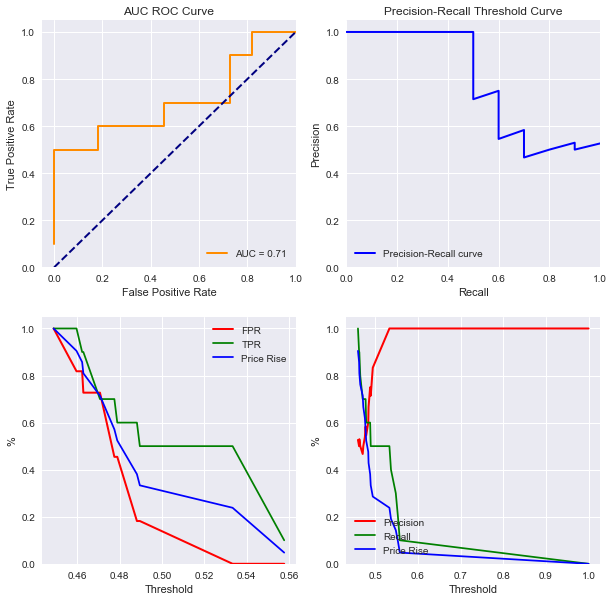

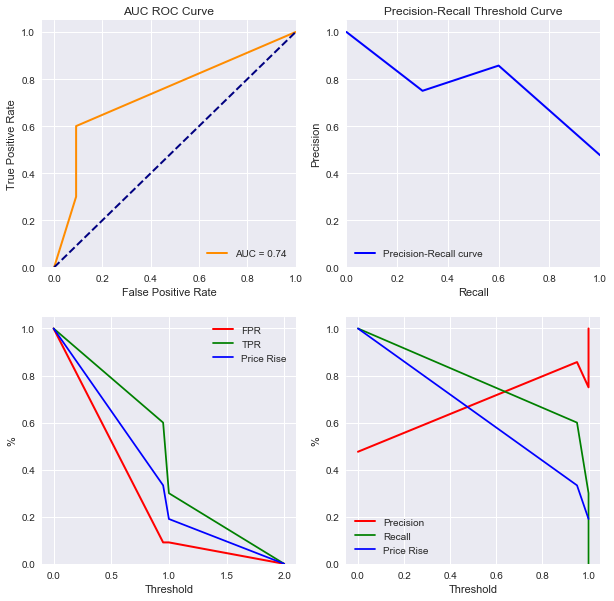

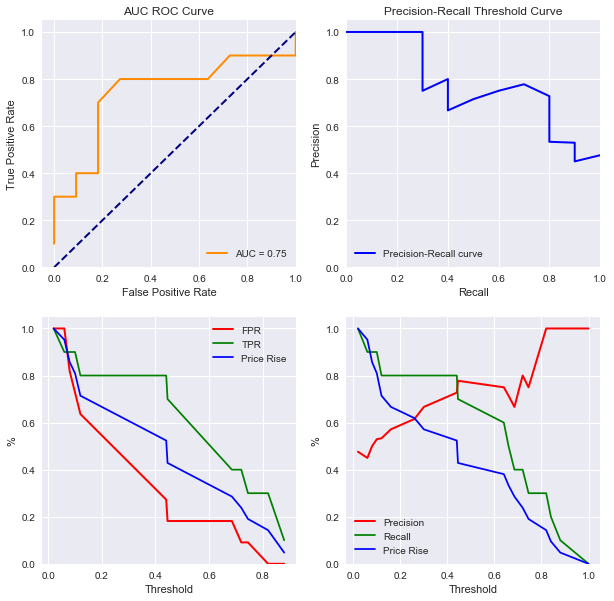

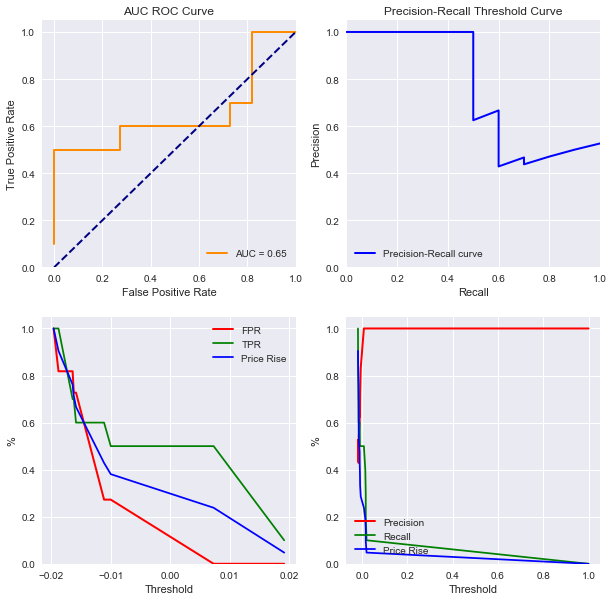

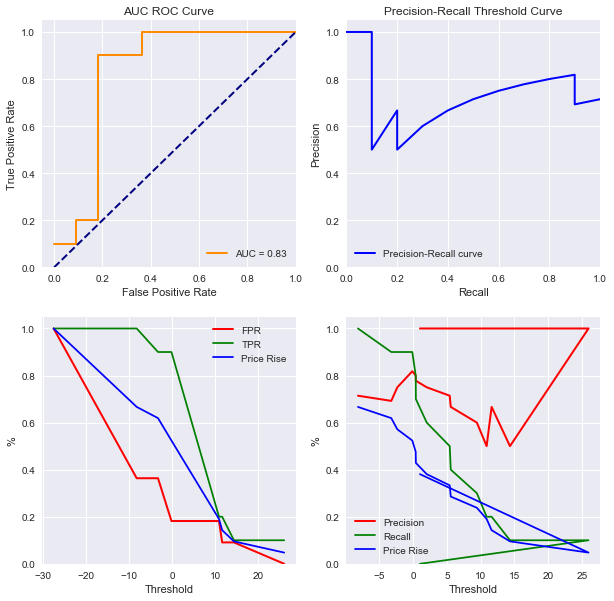

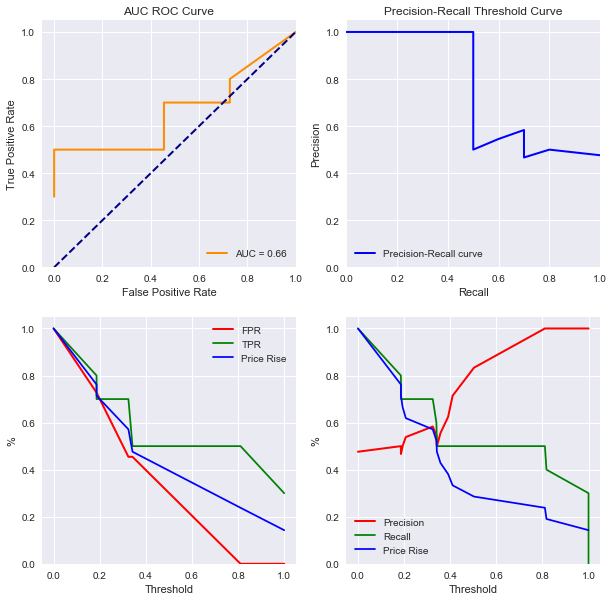

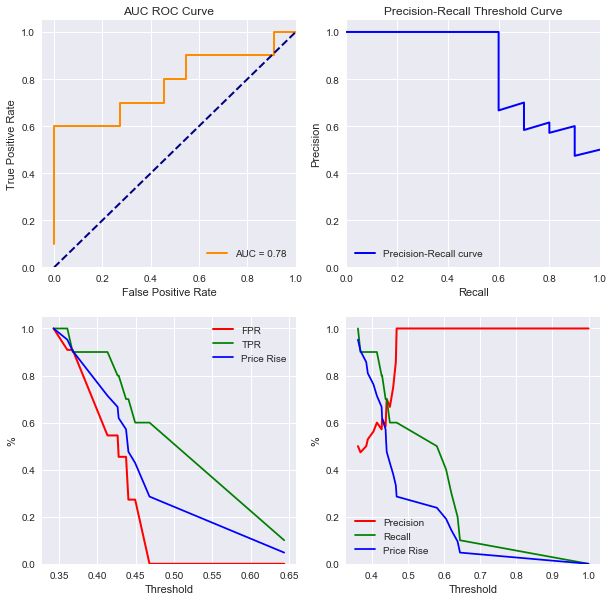

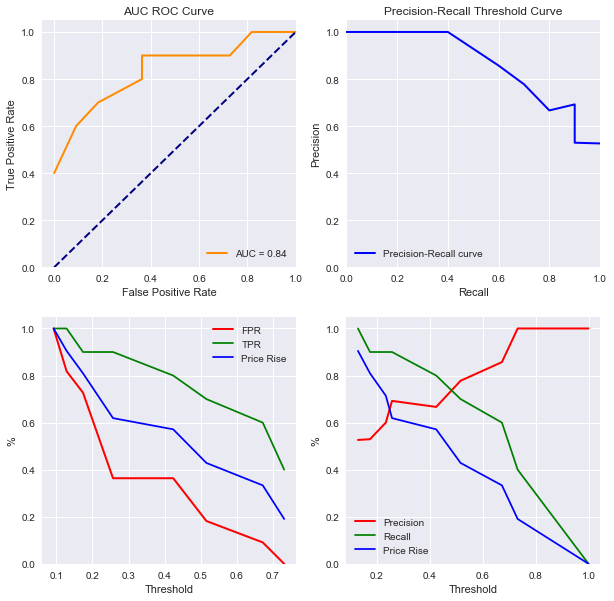

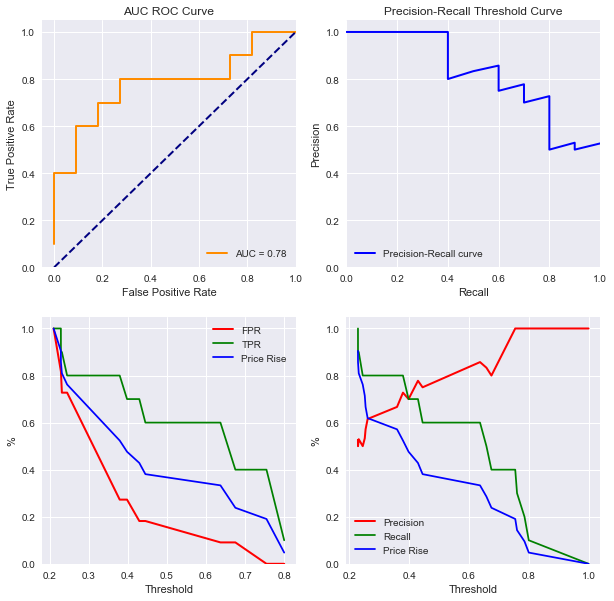

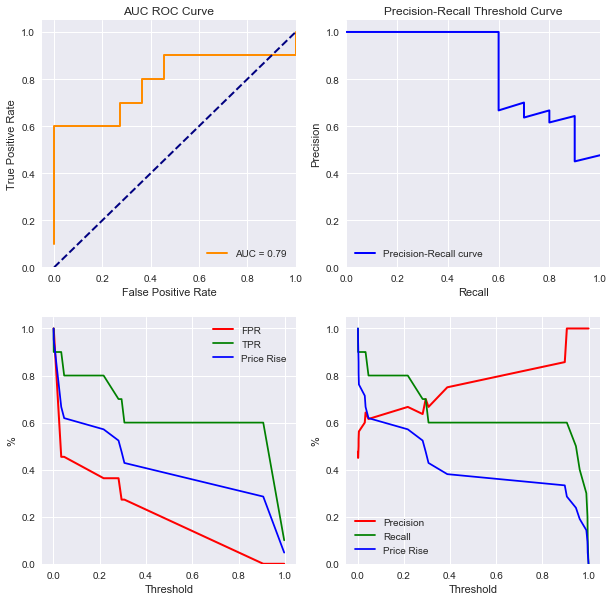

In [302]:
# iterate over classifiers
for model, clf , gs in zip(models, classifiers, grid_search):

    print('\n model: {} \n classifier: {} \n grid search parameters: {}\n\n'.format(model, clf, gs))

    # apply classifier:
    best_estimator, prediction = binary_classifier(data, model, clf, features, params=gs, score='roc_auc')
    print('\nBest Parameters:\n', best_estimator)
    
    # classifier results
    y_result = {'test': data['y_test'], 'pred': prediction.y_pred, 'score': prediction.y_score}

    # measure classifier performance:
    mtrcs, roc, prc = binary_class_metrics(model, y_result, print_out=True, plot_out=True)
    
    # store metrics
    metrics_df[model] = mtrcs

Comparison of all classification models tested:

In [303]:
metrics_df

,Logistic Regression,Decision Tree,Random Forest,SVC,NuSVC,Nearest Neighbors,Neural Nets,Ada Boost,XG Boost,Gradient Boosting
Recall,0.500000,0.600000,0.600000,0.500000,0.800000,0.500000,0.500000,0.700000,0.600000,0.600000
Precision,1.000000,0.857143,0.750000,1.000000,0.800000,0.833333,1.000000,0.777778,0.857143,0.857143
F1 Score,0.666667,0.705882,0.666667,0.666667,0.800000,0.625000,0.666667,0.736842,0.705882,0.705882
ROC AUC,0.709091,0.740909,0.745455,0.654545,0.827273,0.663636,0.781818,0.836364,0.781818,0.790909
Accuracy,0.761905,0.761905,0.714286,0.761905,0.809524,0.714286,0.761905,0.761905,0.761905,0.761905


## 4.- Conclusions
<a id='section4'></a>

We have applied a set of classification algorithms to time bars created from a series of E-mini S&P 500 futures tick data. Specifically, we have made a comparative analysis of the following binary classification algos:

- Logistic Regression
- Decision Tree
- Random Forest
- SVC
- NuSVC
- Nearest Neighbors
- Neural Nets
- Ada Boost
- XG Boost
- Gradient Boosting

The features used in the ML algo has been constructed according to technical analysis theory. We have proved two strategies:

- Alternative 1: predict if price at time $t$ will rise or drop according to information up to time $t-1$
- Alternative 2: predict if we should buy o sell the stock at time $t$ considering information up to time $t-1$

We have seen that the ML algorithm had very low predictive power in alternative 1. The AUC from the ROC indicated that the algo does not perform much better then random guessing. On the other hand, in the case of alternative 2 we were able to have better predictions. However further study is needed, specifically in the sampling and construction of features.

We have used `scikit-learn` for ML and `ta-lib` python library for the feature building. We have made use of `GridSearch` to search in the hyperparameter space.